# 0. Imports packages, modules and functions

## 0.1. Packages and modules

In [52]:
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt

from IPython.display            import Image
from scipy                      import stats
from boruta                     import BorutaPy
from imblearn.combine           import SMOTETomek
from sklearn.preprocessing      import RobustScaler, MinMaxScaler
from sklearn.preprocessing      import OneHotEncoder
from sklearn.ensemble           import RandomForestRegressor
from sklearn.model_selection    import train_test_split
from sklearn.ensemble           import RandomForestClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.model_selection    import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve


from xgboost import XGBClassifier

import datetime
import inflection
import math
import pickle

%matplotlib inline

## 0.2. Helper functions

In [50]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

def get_class_count(df, identification, target_var):
    
    class_count = df.groupby([target_var])[identification].nunique()
    return {key: class_count[key] for key in list(class_count.keys())}

def get_class_proportion(df, identification, target_var):
    
    class_counts = get_class_count(df, identification , target_var)
    return {val[0]: round(100 * val[1]/df.shape[0], 2) for val in class_counts.items()}


In [ ]:
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

## 0.3. Image controls

## 0.4. Loading data

In [4]:
data_raw = pd.read_csv('dataset/churn.csv')
#data_raw.head()

# 1. Data description

In [5]:
data_frame_1 = data_raw.copy()

## 1.1. Renaming the columns

The dataset comes with the kamel case naming style of columns. In general, this type of writing refers to classes, while snake case refers to variables. Changing the naming style for aesthetics and best practices purposes.

In [6]:
data_frame_1.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [7]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

# Changing write pattern to snakecase
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Renaming
data_frame_1.columns = cols_new
data_frame_1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.2. Data dimension

Before doing any further analysis in the dataset, we must know its size.

In [8]:
print( 'Number of rows:    {}'.format(data_frame_1.shape[0]))
print( 'Number of columns: {}'.format(data_frame_1.shape[1]))

Number of rows:    10000
Number of columns: 14


## 1.3. Data types

For each attribute(column), the data read from the dataset CSV may have a type that does not represents properly the attribute itself. We must know its types and change it, if necessary.

In [9]:
data_frame_1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

For instance, we can see that all categorical attributes, such as surname, gender and geography comes with the object type. The types comes from the library NumPy, which categorizes the values in the dataset between different types of numbers, boolean values and everything else is considered an object. 

## 1.4. Checking NA's

It is common for a dataset to come with NA values in different columns. We must verify how "hollow" is the dataset.

In [10]:
data_frame_1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

From the results above, we can see that there are no NA values in the dataset. However, it is possible to exist inconsistencies in the data.

## 1.5. Descriptive statistical

In order to understand the data behavior in each attribute, it is necessary to understand the statistics behind it. Variables will be divided between numerical and categorical attirbutes, for better understanding.

Numerical attributes will be formed for things such as: age, tenure, balance, credit score, number of products, number of credit cards and estimated salary.

Categorical attributes will inclube both variables with non-numerical values and variables with numerical values that could represent true or false, such as: customer id, surname, geography, gender, has credit card, is active member and exited.

### 1.5.1. Numerical attributes

In [11]:
numerical_att = data_frame_1[['credit_score','age','tenure','balance','num_of_products','estimated_salary']]
numerical_att.head()

,credit_score,age,tenure,balance,num_of_products,estimated_salary
0,619,42,2,0.00,1,101348.88
1,608,41,1,83807.86,1,112542.58
2,502,42,8,159660.80,3,113931.57
3,699,39,1,0.00,2,93826.63
4,850,43,2,125510.82,1,79084.10


In [12]:
# Central tendency - mean, median

mean = pd.DataFrame(numerical_att.apply(np.mean)).T
median = pd.DataFrame(numerical_att.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

std_deviation = pd.DataFrame(numerical_att.apply(np.std)).T
min_value = pd.DataFrame(numerical_att.apply(min)).T
max_value = pd.DataFrame(numerical_att.apply(max)).T
range_values = pd.DataFrame(numerical_att.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(numerical_att.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(numerical_att.apply(lambda x: x.kurtosis())).T

numerical_att_stats = pd.concat([min_value, max_value, range_values, mean, median, std_deviation, skew, kurtosis]).T.reset_index()
numerical_att_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
numerical_att_stats

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,credit_score,350.00,850.00,500.00,650.528800,652.000,96.648466,-0.071607,-0.425726
1,age,18.00,92.00,74.00,38.921800,37.000,10.487282,1.011320,1.395347
2,tenure,0.00,10.00,10.00,5.012800,5.000,2.892030,0.010991,-1.165225
3,balance,0.00,250898.09,250898.09,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
4,num_of_products,1.00,4.00,3.00,1.530200,1.000,0.581625,0.745568,0.582981
5,estimated_salary,11.58,199992.48,199980.90,100090.239881,100193.915,57507.617221,0.002085,-1.181518


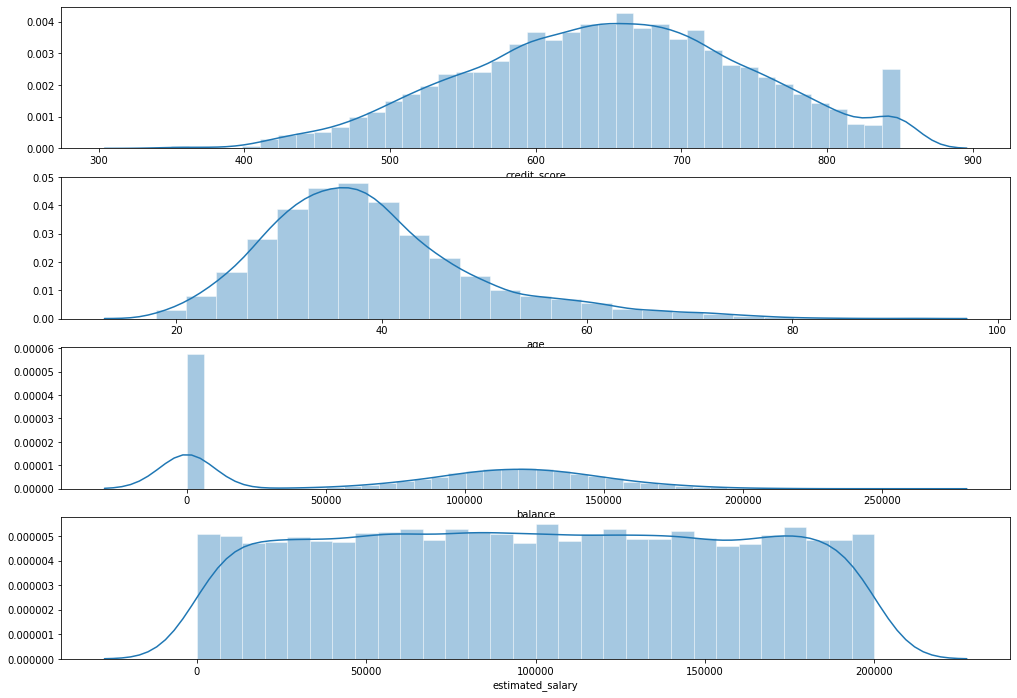

In [13]:
#fig = plt.figure(figsize=(20,10))
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(17,12))

sns.set_style("ticks")
#sns.axes_style("darkgrid")

sns.distplot(data_frame_1['credit_score'], ax=ax[0])
sns.distplot(data_frame_1['age'], ax=ax[1],bins=25)
sns.distplot(data_frame_1['balance'], ax=ax[2],bins=40)
sns.distplot(data_frame_1['estimated_salary'], ax=ax[3], bins=30)


plt.show()

Initial analysis shows that the estimated salary is well distributed along its range, from USD18.00 to almost USD200000.00. Also, the distribution of balance across different clients, shows that there are a high concentration of people with balance of USD0.00, while the median value is USD97000.00. 

### 1.5.2. Categorical attributes

In [14]:
categorical_att = data_frame_1[['customer_id','surname','geography','gender','has_cr_card','is_active_member','exited']]
categorical_att.head()

,customer_id,surname,geography,gender,has_cr_card,is_active_member,exited
0,15634602,Hargrave,France,Female,1,1,1
1,15647311,Hill,Spain,Female,0,1,0
2,15619304,Onio,France,Female,1,0,1
3,15701354,Boni,France,Female,0,0,0
4,15737888,Mitchell,Spain,Female,1,1,0


Before processing and analyzing the categorical variables, first we must undesrtand how many values exists in each categorical attribute.

In [15]:
categorical_att.apply( lambda x: x.unique().shape[0] )

customer_id         10000
surname              2932
geography               3
gender                  2
has_cr_card             2
is_active_member        2
exited                  2
dtype: int64

For instance, there are 10,000 unique customers, while there are 2,932 unique surnames, which means that the surname isn't a interesting variable since could exist two different customers with the same surname. Also, it is highly unlikely that a surname will have any impact on churn prediction.

In [16]:
categorical_att['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

For geography, we can see that clients comes from 3 different countries, such as: France, Spain and Germany

Despite the gender variable, which could be only male or female, all other categorical variables represents a true or false statement.

# 2. Feature Engineering

In [17]:
data_frame_2 = data_frame_1.copy()

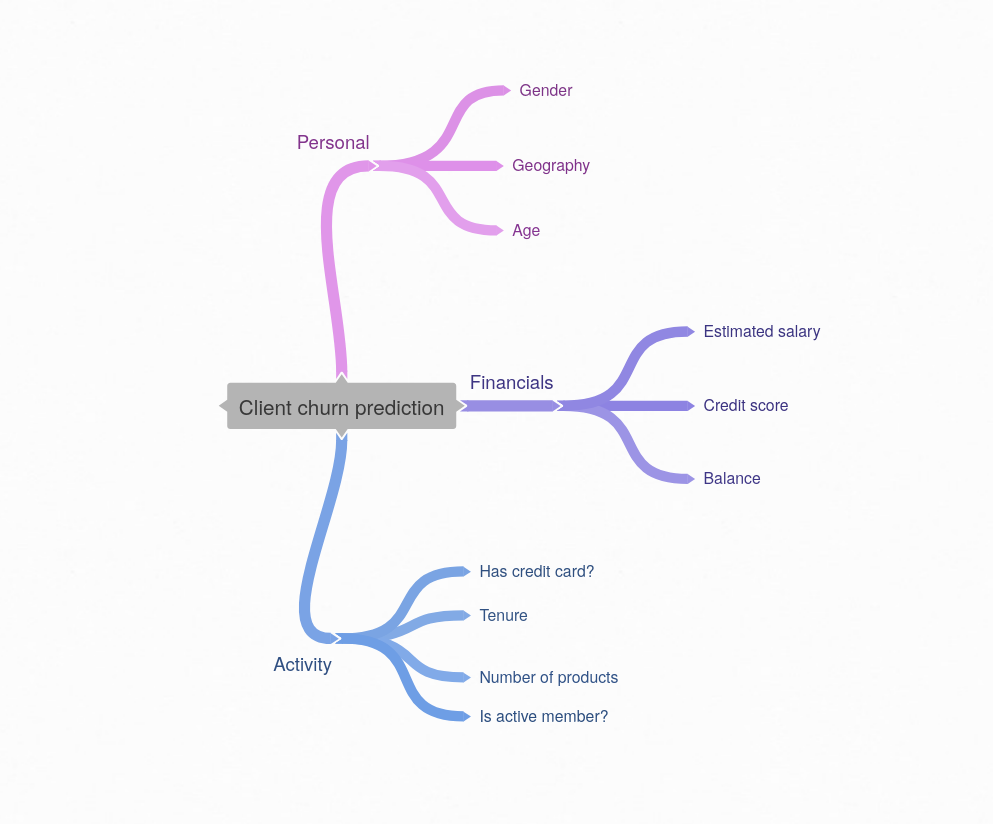

In [18]:
Image('img/MindMapHypothesis.png')

## 2.1. Hypothesis mental map

### 2.1.1. Personal information

**1.** Clients with higher age **should** have a lesser probability of changing its consuming habits, thus reducing the churn probability

**2.** Clients from different nationalities **should** have different probabilities of churn, since the cultural differences **may** impact consuming habits

**3.** Male and female clients **should** have different churn probabilities, since gender **may** have some impact on consuming habits

### 2.1.2. Client financials

**4.** Clients with higher salaries **should** have a higher probability of churn, since other companies **may** try to attract them.

**5.** Clients with higher credit score **should** have a higher probability of churn, since other companies **may** try to attract them.

**6.** Clients with higher balance **should** have a higher probability of churn, since other companies **may** try to attract them.

### 2.1.3. Activity information

**7.** Clients that have a credit card **should** have a lesser probability of churn

**8.** Clients with higher tenure **should** have a lesser probability of churn

**9.** Clients that uses a higher number of products **should** have a lesser probability of churn

**10.** Active clients **should** have a lesser probability of churn

## 2.2. Hypothesis priorization

The hypothesis priorization should be organized both in sense to test which hypothesis is true or based based on data **already** available and in which hypothesis there are some indications that have a higher impact on the churn prediction.

For example, we could consider this priorization:

**1.** Active clients **should** have a lesser probability of churn

**2.** Clients that uses a higher number of products **should** have a lesser probability of churn

**3.** Clients with higher tenure **should** have a lesser probability of churn

**4.** Clients with higher balance **should** have a higher probability of churn, since other companies **may** try to attract them.

**5.** Clients with higher credit score **should** have a higher probability of churn, since other companies **may** try to attract them

**6.** Clients with higher salaries **should** have a higher probability of churn, since other companies **may** try to attract them.

**7.** Clients that have a credit card **should** have a lesser probability of churn

**8.** Clients with higher age **should** have a lesser probability of changing its consuming habits, thus reducing the churn probability

**9.** Clients from different nationalities **should** have different probabilities of churn, since the cultural differences **may** impact consuming habits

**10.** Male and female clients **should** have different churn probabilities, since gender **may** have some impact on consuming habits

In this example, we are considering that information that somehow measures how active the client uses the product have a higher impact than the client's gender or geography.

## 2.3. Feature engineering

At this moment, we should make some transformations on the dataset in a way, such as it could be easier to manipulate the data on the next step and/or transforming existing data in new variables, such as divinding one date into day, month and year. For this dataset, is doest not seem necessary to work on this step.

# 3. Variable filtering

For each problem involving data science and analytics, the dataset may contain information that only does not help understanding the problem, but also may increase its difficulty. To solve this problem, we must filter the information before advancing to the exploratory data analysis. The information can be filtered by two different means: by the lines or by the columns.

## 3.1. Lines filtering

The line filtering involves removing information that are not reliable, does not helps the interpretation or the value of target variable have an important business meaning that explain the line removal.

For example, in a problem involving a store sales prediction, the information contained on a line informing sales of 0 in one day, may represents that, on this day, the store was closed. And this fact, **may** justify the line information.

For this dataset, we have 10,000 lines with 10,000 different customersId and we only have values for the target variable of 0 or 1, meaning that the customer churned or not, so we will not remove any lines.

## 3.2. Columns filtering

Each column in a dataset represent one variable or some aspect of one variable (such as time could be divided in different variables, such as year, month and day), thus making the columns filtering the equivalent of variable filtering.

In this dataset, we can see that there are information that does not help the client churn prediction, for example: surname, row number and customer ID. It is highly unlikely that those variables will have any impact on any prediction model. Thus, we will be removing the surname and row number columns and will keep the customer's ID **only** for data traceability.

In [19]:
cols_drop = ['row_number','surname']

data_frame_2.drop(cols_drop, axis=1)

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


This change in the dataset reduces the dimensions from 10,000 rows and 14 columns to 10,000 rows and **12** columns

# 4. Exploratory data analysis

In [20]:
data_frame_4 = data_frame_2.copy()

On the exploratory data analysis the main objective is to extract insights for the business problem, by: **(a).** confirming or rejecting the hypothesis created, **(b).** proving wrong old beliefs from the business team or **(c).** finding new information that helps the business team.

## 4.1. Univariate analysis

On the first step of the analysis, we will study how the response variable interacts with the variation of the others variables and asking the questions:

**(i).** Is it expected to see this behavior?

**(ii).** Does the business team knows this behavior?

**(iii).** Is there any business reason that explains this behavior?

### 4.1.1. Response variable

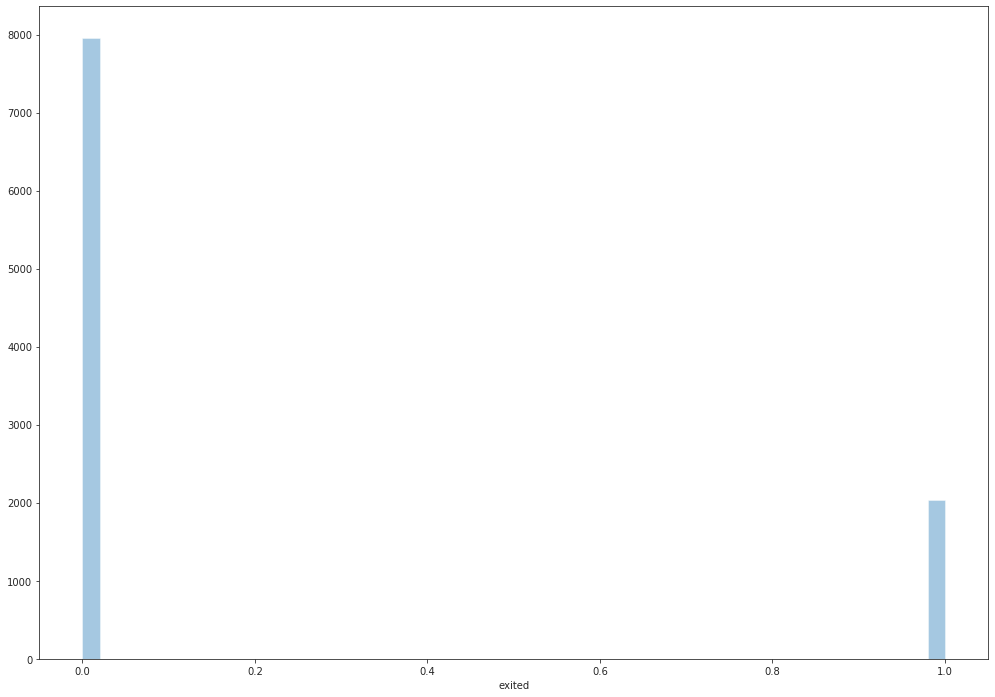

In [21]:
#fig = plt.figure(figsize=(20,10))
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(17,12))

sns.set_style("ticks")

sns.distplot(data_frame_4['exited'], kde=False, rug=False )


plt.show()

From the distribution graph, we can see that the proportion between customers that have churned is 20\% of the dataset, while clients that have not churn is 80\%. With this information we already know that we are dealing with a problem of disbalanced data, thus making necessary using appropriated methods for those types of problems.

### 4.1.2 Numerical variables

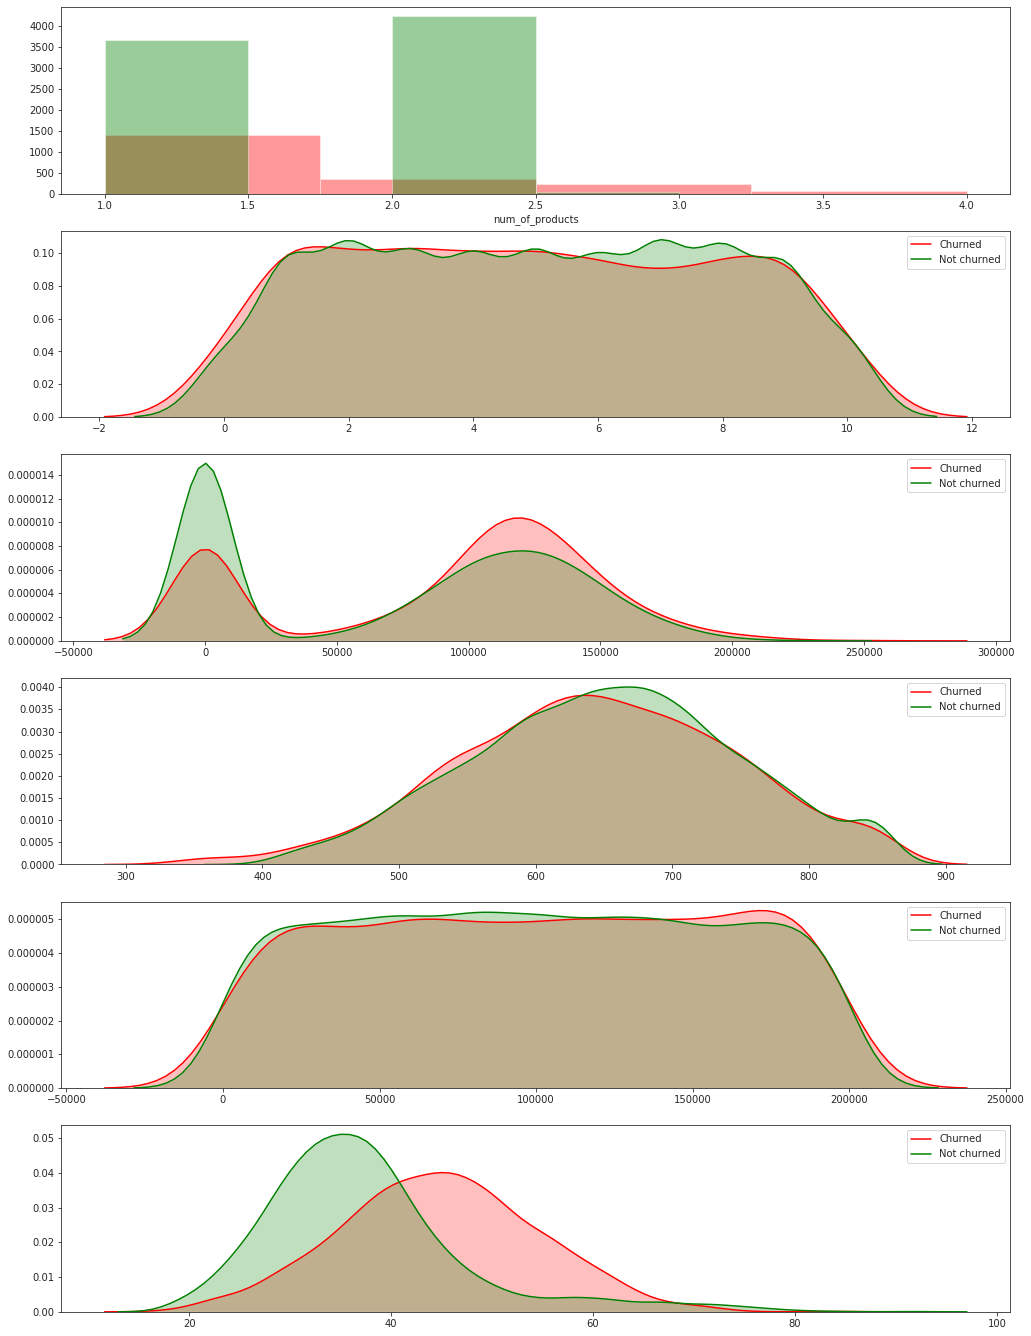

In [22]:
#fig = plt.figure(figsize=(20,10))
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(17,24))

sns.set_style("ticks")

# Plot 1
sns.distplot( data_frame_4[data_frame_4['exited'] == 1]['num_of_products'], label='Churned', ax=ax[0], kde=False, bins=4, color='red')
sns.distplot( data_frame_4[data_frame_4['exited'] == 0]['num_of_products'], label='Not churned', ax=ax[0], kde=False, bins=4, color='green')

# Plot 2
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['tenure'], label='Churned', shade=True, ax=ax[1], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['tenure'], label='Not churned', shade=True, ax=ax[1], color='green')

# Plot 3
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['balance'], label='Churned', shade=True, ax=ax[2], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['balance'], label='Not churned', shade=True, ax=ax[2], color='green')

# Plot 4
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['credit_score'], label='Churned', shade=True, ax=ax[3], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['credit_score'], label='Not churned', shade=True, ax=ax[3], color='green')

# Plot 5
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['estimated_salary'], label='Churned', shade=True, ax=ax[4], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['estimated_salary'], label='Not churned', shade=True, ax=ax[4], color='green')

# Plot 6
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['age'], label='Churned', shade=True, ax=ax[5], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['age'], label='Not churned', shade=True, ax=ax[5], color='green')


plt.show()

From the graphs, we can already evalute some of the hypothesis from the section 2: 

**2.**  Clients that uses a higher number of products **should** have a lesser probability of churn. From graph 1, we can see that most of the churn customers (around 1,500 or 75% of all churned customers) only consumes a single product from the company, while most of the customers uses 2 products (around 4,000 or 40% of all customers). Also, we see that almost every customer that used 3 or 4 products became churn. Thus, making this hypothesis **partially false**, while having a single product the customer has a higher probability of churn, increasing the products to 3 or 4 also increases the probability of churn.

**3.** Clients with higher tenure **should** have a lesser probability of churn. From graph 2, we can see that this hypothesis is also **false**, since there almost the same proportion of churn and not churned customers across different values of tenure.

**4.** Clients with higher balance **should** have a higher probability of churn, since other companies **may** try to attract them. Graph 3 shows that the proportion of churned and not churned customers is different, for different values of balance. For instance, we can see that there is a higher proportion of not churned customers with USD0.00 balance, while a higher proportion of churned customers with a higher balance, peaking at around USD125,000.00. So, this hypothesis is **true**.

**5.** Clients with higher credit score **should** have a higher probability of churn, since other companies **may** try to attract them. The data shows almost no difference in credit score and churn probability, thus making this hypothesis **false**.

**6.** Clients with higher salaries **should** have a higher probability of churn, since other companies **may** try to attract them. This hypothesis is also **false**, since there are no significant difference in churned and not churned customers across different values of salary.

**8.** Clients with higher age **should** have a lesser probability of changing its consuming habits, thus reducing the churn probability. From the last graph, we can see that the increase of age impacts negatively on the probability of churn, making the hypothesis **false**.  

### 4.1.3. Categorical variables

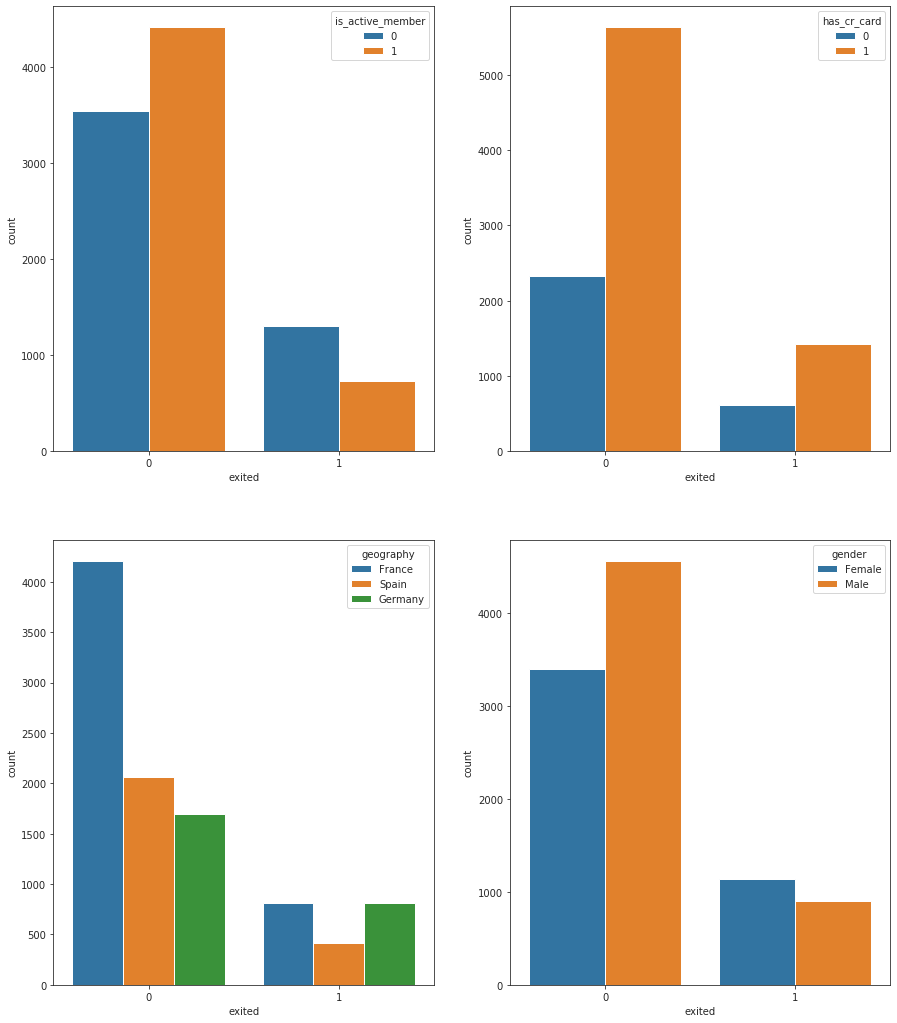

In [23]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,18))

sns.set_style("ticks")
#sns.axes_style("darkgrid")

sns.countplot(x="exited", hue="is_active_member", data=categorical_att, ax=ax[0,0])
sns.countplot(x="exited", hue="gender", data=categorical_att, ax=ax[1,1])
sns.countplot(x="exited", hue="has_cr_card", data=categorical_att, ax=ax[0,1])
sns.countplot(x="exited", hue="geography", data=categorical_att, ax=ax[1,0])
#sns.catplot(x="geography", y="exited", hue="has_cr_card",kind="violin", split=True, data=categorical_att)
#sns.catplot(x="geography", y="exited", hue="is_active_member",kind="violin", split=True, data=categorical_att)


plt.show()

**1.** Active clients **should** have a lesser probability of churn. The first graph shows that the more active a customer is, the lesser is the probability of becoming churn. So, the hypothesis is **true**.

**7.** Clients that have a credit card **should** have a lesser probability of churn. Clients with credit card becomes churn in a slightly lesser proportion (1424/5631 or 25%) than client without credit card (613/2332 or 26%). Thus, making the hypothesis **partially true**.

**9.** Clients from different nationalities **should** have different probabilities of churn, since the cultural differences **may** impact consuming habits. German customershave a higher probability to become churn, while french customers have a lesser probability, making the hypothesis **true**.

**10.** Male and female clients **should** have different churn probabilities, since gender **may** have some impact on consuming habits. The last graph shows that male customers have a lower probability of becoming churn compared to female customers, making the hypothesis **true**.

## 4.2. Bivariate analysis

From the analysis done before, we have observed that the features which causes the most variation in churn or not churn probability for numerical variables are: age, balance and number of products and the categorical attributes are: active member, geography and gender.

Those observations brings some more hypothesis to be made, such as:

**11.** Active member churn probability **could** be different for men and women.

**12.** Active member churn probability **could** be different different ages.

**13.** Men and women from different countries **could** have different churn probabilities.

**14.** Men and women with different ages **could** have different churn probabilities.

**15.** People with different age along each country **could** have different churn probabilities.

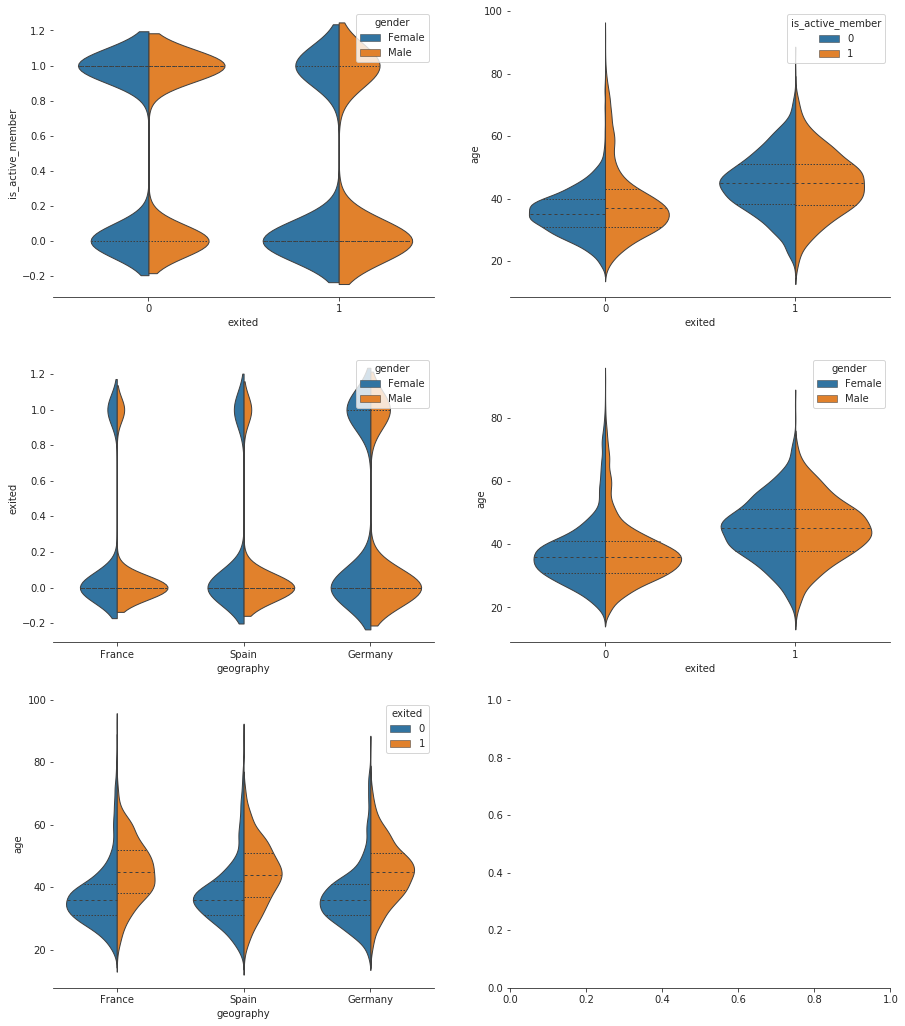

In [24]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(15,18))

# Plot 1
sns.violinplot(data=data_frame_4, x="exited", y="is_active_member", hue="gender", split=True, inner="quart", linewidth=1, ax=ax[0,0])


# Plot 2
sns.violinplot(data=data_frame_4, x="exited", y="age", hue="is_active_member", split=True, inner="quart", linewidth=1, ax=ax[0,1])

# Plot 3
sns.violinplot(data=data_frame_4, x="geography", y="exited", hue="gender", split=True, inner="quart", linewidth=1, ax=ax[1,0])

# Plot 4
sns.violinplot(data=data_frame_4, x="exited", y="age", hue="gender", split=True, inner="quart", linewidth=1, ax=ax[1,1])

# Plot 5
sns.violinplot(data=data_frame_4, x="geography", y="age", hue="exited", split=True, inner="quartiles", linewidth=1, ax=ax[2,0])



sns.despine(left=True)
plt.show()

**11.** Active member churn probability **could** be different for men and women. From the first graph, differences between male and female exited customers are not clear among active and inactive members. So, the hypothesis is **false**.

**12.** Active member churn probability **could** be different different ages. From the second graph, we can see that there is a difference in age profile for non churned customers, with a skewness for older clients. However, there are no clear difference of age among churned customers. So, the hypothesis is **false**.

**13.** Men and women from different countries **could** have different churn probabilities. The third graph (first column, second row) shows a higher proportion of male non churned customers while, women have higher churn probability. Also, the graph makes clear how german clients have the highest churn probability. As women have highest churn probability in all countries, the hypothesis is **false**. 

**14.** Men and women with different ages **could** have different churn probabilities. The fourth graph shows that there are no clear evidence that male and female churn probability varies with age. Thus, the hypothesis is **false**.

**15.** People with different age along each country **could** have different churn probabilities. The last graph shows clearly that there is a difference in churned customers with age along all countries available. 

## 4.3. Multivariate analysis

### 4.3.1. Numerical attributes

The multivariate analysis for numerical attributes consists in evaluating the correlation between different variables, without the target, by using Person's correlation.

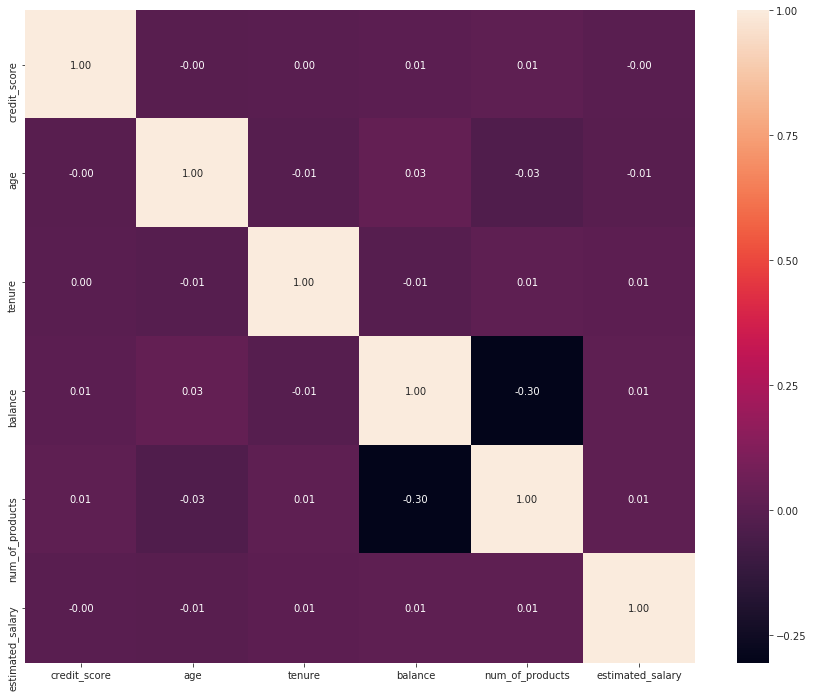

In [25]:
fig, ax = plt.subplots(figsize=(15,12))

correlation = numerical_att.corr(method='pearson')
sns.heatmap(correlation, annot=True, fmt='.2f')

plt.show()

For the dataset we do not observe any correlation between almost all variables, even those which we might think that is correlate, such as: bigger salaries should imply in bigger balances or bigger balances should imply high credit score. However, we do not observe those kind of things. 

The biggest correlation observed is between balance and number of products consumed, which could imply that the lower the balance, the more products are consumed. This correlation could be spurious since there are a lot of customers with USD0.00 balance and a lot of people who consumes two products.

### 4.3.2. Categorical attributes

For categorical attributes, we use the Pearson's chi-squared test to evaluate correlation between those variables. The method used for this calculation can be found at the item **0.2. Helper Functions**.

In [26]:
cat1 = cramer_v(categorical_att['geography'], categorical_att['gender'])
cat2 = cramer_v(categorical_att['geography'], categorical_att['is_active_member'])
cat3 = cramer_v(categorical_att['geography'], categorical_att['has_cr_card'])
#cat4 = cramer_v(categorical_att['geography'], categorical_att['exited'])


cat5 = cramer_v(categorical_att['gender'], categorical_att['geography'])
cat6 = cramer_v(categorical_att['gender'], categorical_att['is_active_member'])
cat7 = cramer_v(categorical_att['gender'], categorical_att['has_cr_card'])
#cat8 = cramer_v(categorical_att['gender'], categorical_att['exited'])

cat9 = cramer_v(categorical_att['is_active_member'], categorical_att['gender'])
cat10 = cramer_v(categorical_att['is_active_member'], categorical_att['geography'])
cat11 = cramer_v(categorical_att['is_active_member'], categorical_att['has_cr_card'])
#cat12 = cramer_v(categorical_att['is_active_member'], categorical_att['exited'])

d = pd.DataFrame({'geography': [cat1, cat2, cat3],
              'gender': [cat5, cat6, cat7],
              'is_active_member': [cat9, cat10, cat11] })

d = d.set_index(d.columns)
d.head()

<ipython-input-3-21a11c0d6782>:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(x, y).as_matrix()


,geography,gender,is_active_member
geography,0.026303,0.026303,0.022344
gender,0.023033,0.022344,0.023033
is_active_member,0.014951,0.005545,0.011646


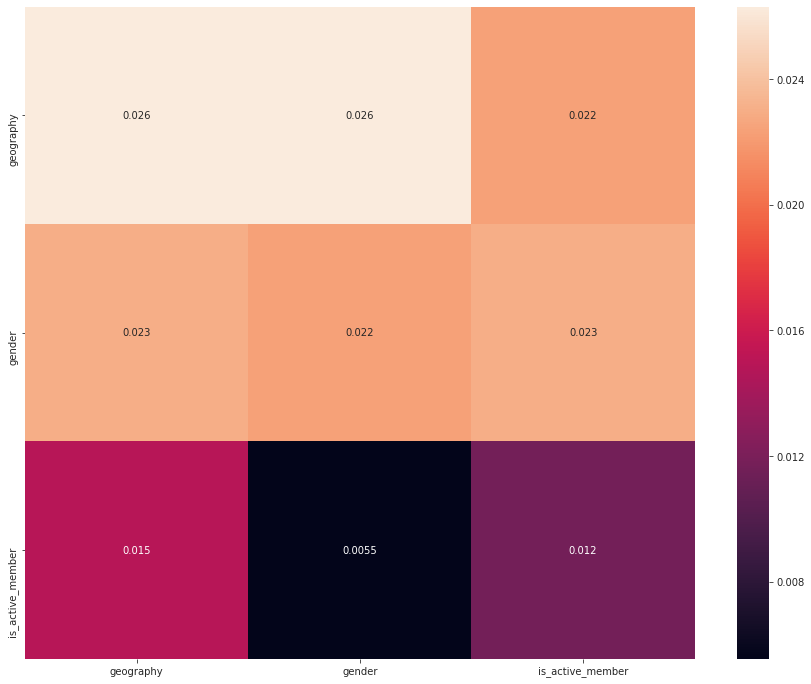

In [27]:
fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(d, annot=True)

plt.show()

Even for the categorical attributes, we can not see any clear correlation between the different variables.

# 5. Data preparation

In [28]:
data_frame_5 = data_frame_4.copy()

data_frame_5.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


At this point all data must be properly prepared for the application of machine learning algorithms. The preparation includes: (a) changing variables range of value to a smaller one, so all numerical variables have the same or almost the same importance for the machine learning algorithm, and  (b) transforming categorical attributes into numerical values.

## 5.1. Data normalization

The data normalization is one type of rescaling data where the variable becomes a value with a mean equal of 0 and with a deviation of one. This transformation is good with numerical variables which have a distribution similar to a "bell" curve. For this dataset, all numerical variables seem to have some skewness and/or kurtosis or is a bimodal distribution. So, for this dataset, we will not perform any data normalization.

## 5.2. Data rescaling

In the other hand, the data rescaling have a good performance for variables with a non-normal distribution. The main types of rescaling are: the min-max scaler or the robust scaler. The min-max scaler is good option because it keeps the distribution curve behavior for numerical variables. However, this scaler does not have a good performance for variables with outliers, because the rescaling of data happens by using minimun and maximum values of the variable. The robust scaler method were developed to solve thhe outlier problem, where the rescaling of data uses the first and the last quartile.

For this dataset, we will be using only the min-max scaler as we do not see any problem with outlier values.

In [29]:
mms = MinMaxScaler()

# credit score
data_frame_5['credit_score'] = mms.fit_transform( data_frame_5[['credit_score']].values )
pickle.dump(mms, open('parameters/credit_score.pkl','wb'))

# age
data_frame_5['age'] = mms.fit_transform( data_frame_5[['age']].values )
pickle.dump(mms, open('parameters/age.pkl','wb'))

# tenure
data_frame_5['tenure'] = mms.fit_transform( data_frame_5[['tenure']].values )
pickle.dump(mms, open('parameters/tenure.pkl','wb'))

# balance
data_frame_5['balance'] = mms.fit_transform( data_frame_5[['balance']].values )
pickle.dump(mms, open('parameters/balance.pkl','wb'))

# num_of_products
data_frame_5['num_of_products'] = mms.fit_transform( data_frame_5[['num_of_products']].values )
pickle.dump(mms, open('parameters/num_of_products.pkl','wb'))

# estimated_salary
data_frame_5['estimated_salary'] = mms.fit_transform( data_frame_5[['estimated_salary']].values )
pickle.dump(mms, open('parameters/estimated_salary.pkl','wb'))

data_frame_5.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,0.538,France,Female,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1
1,2,15647311,Hill,0.516,Spain,Female,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0
2,3,15619304,Onio,0.304,France,Female,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1
3,4,15701354,Boni,0.698,France,Female,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0
4,5,15737888,Mitchell,1.000,Spain,Female,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0


## 5.3. Data transformation

For the transformation, we will change the non-numerical attirbutes into numerical values. This dataset has only two variables which behaves this way: geography and gender. We already discussed in other sections that the variable surname will not be considered, since it is highly unlikely that this feature will increase the model's precision.

### 5.3.1. Enconding

The variable gender will be treated with the one hot encoding which creates two other variables with values of 0 or 1. The variables will refer to male or female and if it is 1 for male, it will be 0 for female. This way we can represent the differences between gender as observed in the EDA while slightly increasing the model's complexity.

In [30]:
data_frame_5 = pd.get_dummies(data_frame_5, prefix='gender', columns=['gender'])
data_frame_5.head()

,row_number,customer_id,surname,credit_score,geography,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Female,gender_Male
0,1,15634602,Hargrave,0.538,France,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1,0
1,2,15647311,Hill,0.516,Spain,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,1,0
2,3,15619304,Onio,0.304,France,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1,0
3,4,15701354,Boni,0.698,France,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1,0
4,5,15737888,Mitchell,1.000,Spain,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,1,0


However, for the geography we will not be using the one hot enconding, since it would increase our dimensionality in 2 new variables, by spliting geography in 3. Since we saw that there is evidence that the country changes the probability of churn, we will be using the mean or target enconding. It is done by using mean value between all target values found for a single characteristic of the categorical variable and divide by the number of times this characteristic appears.  

In [31]:
mean_encode = data_frame_5.groupby('geography')['exited'].mean()

data_frame_5.loc[:, 'geography_mean_enc'] = data_frame_5['geography'].map(mean_encode)

data_frame_5

,row_number,customer_id,surname,credit_score,geography,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Female,gender_Male,geography_mean_enc
0,1,15634602,Hargrave,0.538,France,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1,0,0.161548
1,2,15647311,Hill,0.516,Spain,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,1,0,0.166734
2,3,15619304,Onio,0.304,France,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1,0,0.161548
3,4,15701354,Boni,0.698,France,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1,0,0.161548
4,5,15737888,Mitchell,1.000,Spain,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,1,0,0.166734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,0.842,France,0.283784,0.5,0.000000,0.333333,1,0,0.481341,0,0,1,0.161548
9996,9997,15569892,Johnstone,0.332,France,0.229730,1.0,0.228657,0.000000,1,1,0.508490,0,0,1,0.161548
9997,9998,15584532,Liu,0.718,France,0.243243,0.7,0.000000,0.000000,0,1,0.210390,1,1,0,0.161548
9998,9999,15682355,Sabbatini,0.844,Germany,0.324324,0.3,0.299226,0.333333,1,0,0.464429,1,0,1,0.324432


### 5.3.2. Response variable transformation

At this point, it could be necessary to transform the values in the target variable, so its range could also be reducted. However, our target is already in a well behaved range from 1 (churned customer) to 0 (not churned). So, it will not be done any modification in the response variable.

# 6. Feature selection

In [32]:
data_frame_6 = data_frame_5.copy()

At this point, it is necessary to select the most relevant features to train and test the model. Since we have a small number of features, the selection could be done manually or by using a feature selector method/function, such as the Boruta.

The selected features that will be chosen manually for the training will be: credit score, geography mean encode, tenure, balance, age, estimated salary, number of products, has credit card, is active member, gender female and gender male.

So, the features: customer ID, row number, surname and original geography will not be used.

In [76]:
manual_selected = ['credit_score','age','tenure',
                   'balance','num_of_products','has_cr_card', 
                   'is_active_member','gender_Female','gender_Male',
                   'geography_mean_enc', 'estimated_salary']
data_frame_6['exited'] = data_frame_6['exited'].astype(float)

Removing unnecessary data

In [77]:
x_train = data_frame_6.drop(['customer_id','row_number','surname', 'geography', 'exited'], axis=1)

y_train = data_frame_6['exited'].copy()


However, we can also use a feature selection algorithm to evaluate the what are the most important features. The chosen algorithm will be the random forest regressor.

In [78]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(x_train, y_train)

feature_imp = pd.DataFrame({'Feature':x_train.columns, 'feature_importance': rf.feature_importances_}).sort_values('feature_importance', ascending=False).reset_index(drop=True)

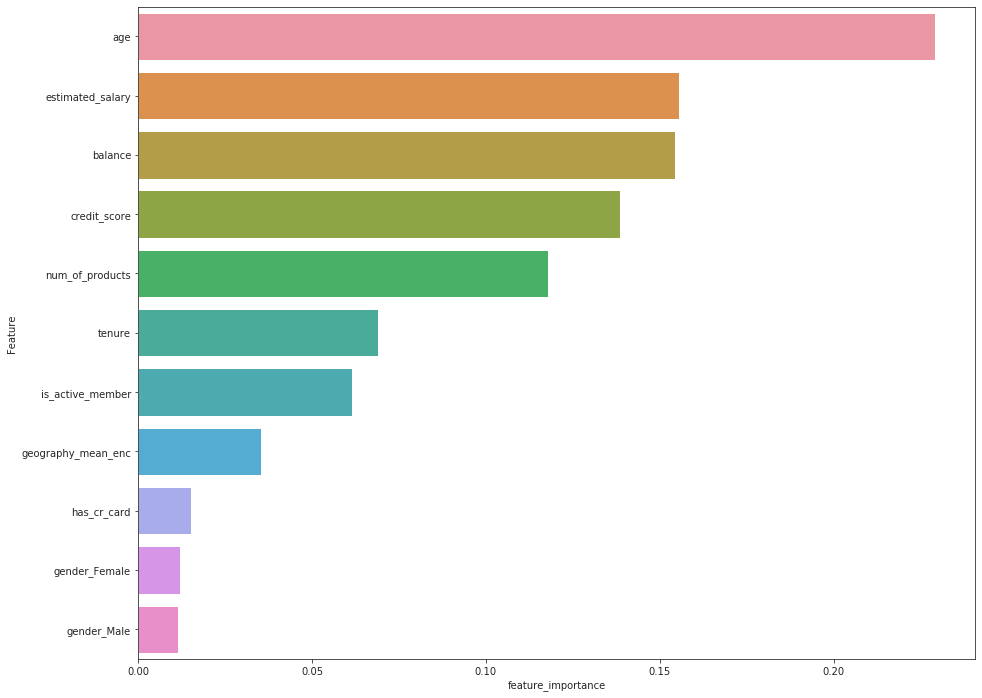

In [79]:
fig, ax = plt.subplots(figsize=(15,12))

sns.barplot(x='feature_importance', y='Feature', data=feature_imp, orient='h')

plt.show()

In [80]:
x_train_boruta = x_train.values
y_train_boruta = y_train.values.ravel()

boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_boruta ,y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	7


BorutaPy

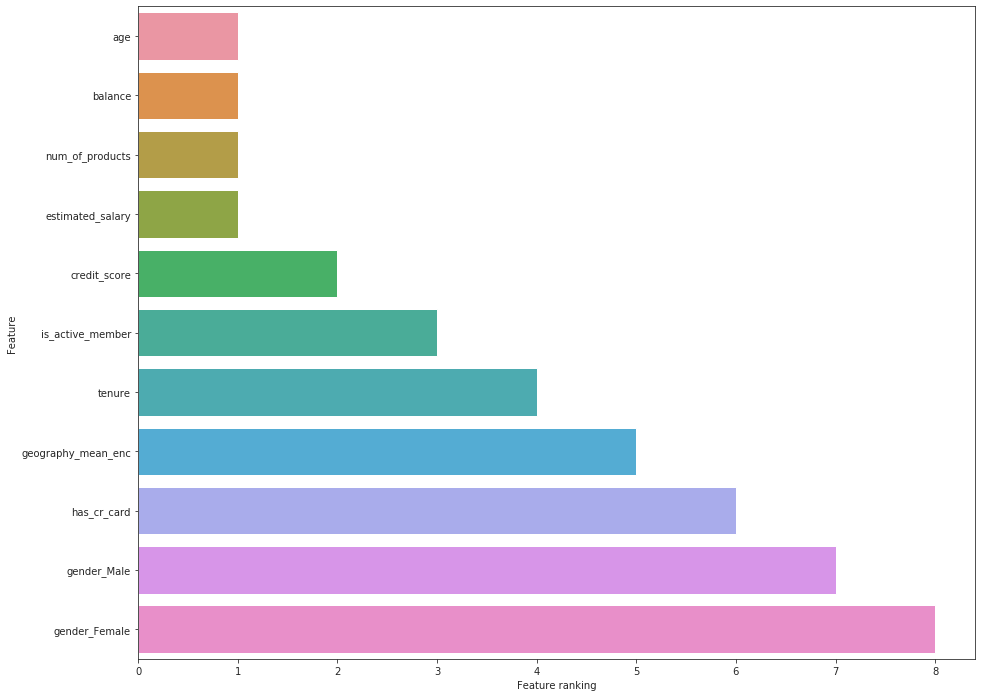

In [81]:
d = {'Features':x_train.columns, 'feature_importance': boruta.ranking_}
features_boruta = pd.DataFrame(d).sort_values('feature_importance', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15,12))

ax = sns.barplot(x='feature_importance', y='Features', data=features_boruta, orient='h')

ax.set(xlabel='Feature ranking', ylabel='Feature')

plt.show()

Boruta and the random forest regressor concludes the same things, the age, balance and estimated salary are the most important features while the gender for female or male are the least important. The result is controversial as the EDA shows that there are different proportion for men and women with churn. 

In the first model, we will keep all the features above, however in a next attempt for model optimization we may need to create new features.

# 7. Machine learning modelling

## 7.1. Balancing data for training

One problem with the dataset is that it is highly unbalanced with a total proportion of 80% of customers not churned and 20% of churned customers.

To solve this problem, the data for training and for testing will be balanced.

In [82]:
# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# resample the dataset
x_balanced, y_balanced = resampler.fit_resample(x_train, y_train)

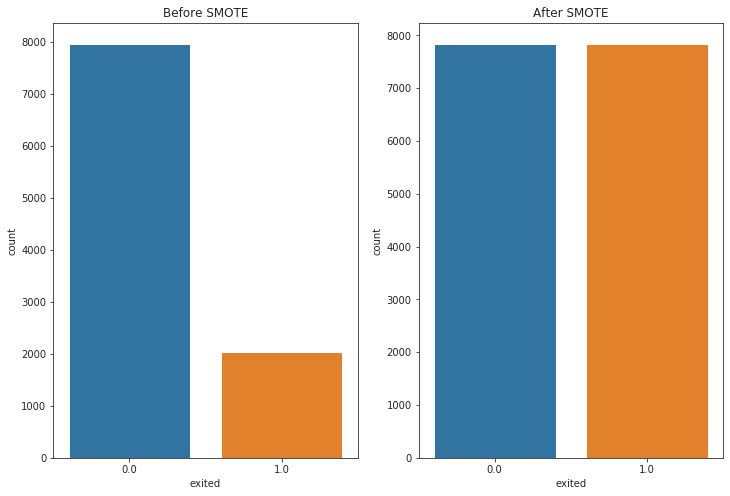

In [83]:
 # plots before and after SMOTETomek
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_balanced)
plt.title("After SMOTE")

plt.show()

## 7.2. Logistic regression

### 7.2.1. Unbalanced data

In [108]:
 # instantiate the model
logit = LogisticRegression()

# fit the model
logit.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
logit_performance = performance(logit, x_train, y_train)
logit_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.8124,0.626795,0.201304,0.30304,0.585018,0.276535


In [109]:
logit_y_pred = cross_val_predict(logit, x_train, y_train, cv=10)

logit_cm = confusion_matrix(y_train, logit_y_pred)

logit_cm_df = pd.DataFrame(logit_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

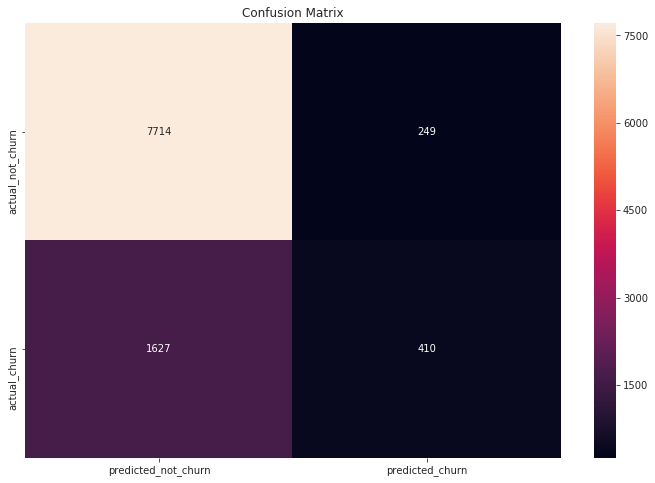

In [110]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(logit_cm_df, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

### 7.2.2. Balanced data

In [111]:
 # instantiate the model
logit = LogisticRegression()

# fit the model
logit.fit(x_balanced, y_balanced)

# model performance with performance function. For more details, please see Helper Functions section.
logit_performance_bal = performance(logit, x_balanced, y_balanced)
logit_performance_bal

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.722462,0.724632,0.718004,0.721149,0.722463,0.445129


In [112]:
logit_y_pred_bal = cross_val_predict(logit, x_balanced, y_balanced, cv=10)

logit_cm_bal = confusion_matrix(y_balanced, logit_y_pred_bal)

logit_cm_df_bal = pd.DataFrame(logit_cm_bal, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

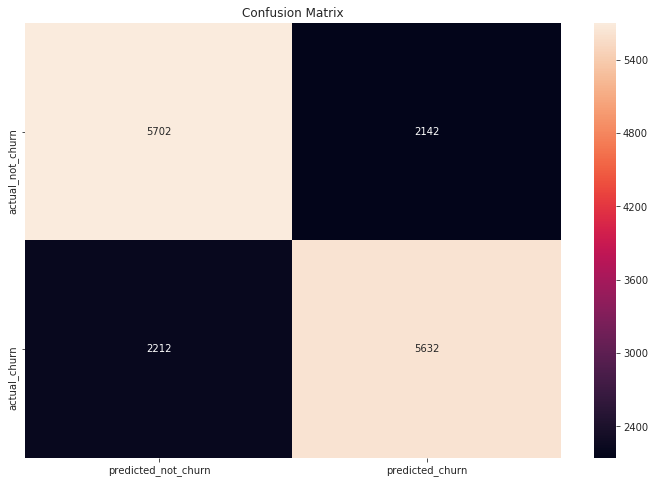

In [113]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(logit_cm_df_bal, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

## 7.3. Random forest

### 7.3.1. Unbalanced data

In [114]:
 # instantiate the model
rfc = RandomForestClassifier(random_state=42,n_jobs=-1)

# fit the model
rfc.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
rfc_performance = performance(rfc, x_train, y_train)
rfc_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.8628,0.76432,0.473237,0.583044,0.717844,0.528204


In [115]:
rfc_y_pred = cross_val_predict(rfc, x_train, y_train, cv=10)

rfc_cm = confusion_matrix(y_train, rfc_y_pred)

rfc_cm_df = pd.DataFrame(rfc_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

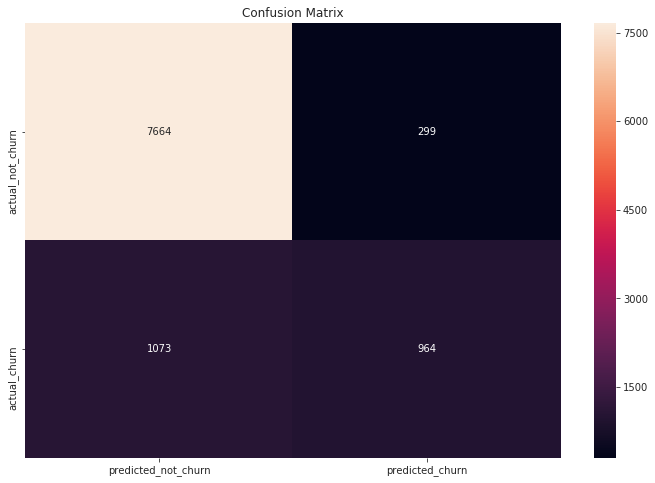

In [116]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(rfc_cm_df, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

### 7.3.2. Balanced data

In [117]:
 # instantiate the model
rfc = RandomForestClassifier(random_state=42,n_jobs=-1)

# fit the model
rfc.fit(x_balanced, y_balanced)

# model performance with performance function. For more details, please see Helper Functions section.
rfc_performance_bal = performance(rfc, x_balanced, y_balanced)
rfc_performance_bal

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.912485,0.919368,0.903545,0.908224,0.912508,0.829497


In [118]:
rfc_y_pred_bal = cross_val_predict(rfc, x_balanced, y_balanced, cv=10)

rfc_cm_bal = confusion_matrix(y_balanced, rfc_y_pred_bal)

rfc_cm_df_bal = pd.DataFrame(rfc_cm_bal, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

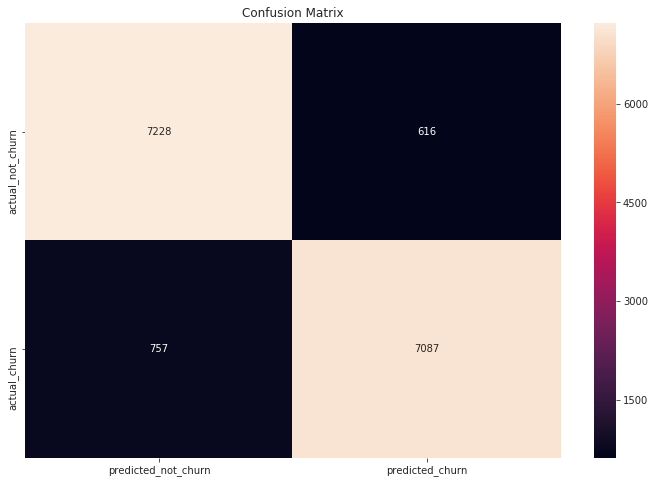

In [119]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(rfc_cm_df_bal, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

## 7.4. XGBoost model

### 7.4.1. Unbalanced data

In [120]:
 # instantiate the model
xgbc = XGBClassifier(random_state=42,n_jobs=-1)

# fit the model
xgbc.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
xgbc_performance = performance(rfc, x_train, y_train)
xgbc_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.8628,0.76432,0.473237,0.583044,0.717844,0.528204


In [121]:
xgbc_y_pred = cross_val_predict(xgbc, x_train, y_train, cv=10)

xgbc_cm = confusion_matrix(y_train, xgbc_y_pred)

xgbc_cm_df = pd.DataFrame(xgbc_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

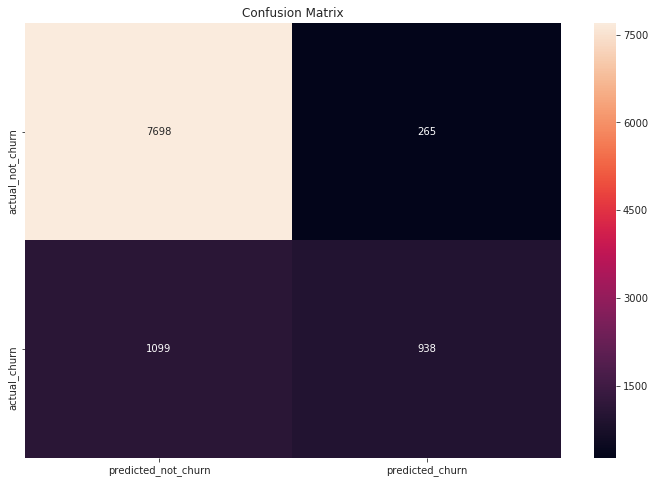

In [122]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(xgbc_cm_df, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

### 7.4.2. Balanced data

In [123]:
 # instantiate the model
xgbc = XGBClassifier(random_state=42,n_jobs=-1)

# fit the model
xgbc.fit(x_balanced, y_balanced)

# model performance with performance function. For more details, please see Helper Functions section.
xgbc_performance_bal = performance(rfc, x_balanced, y_balanced)
xgbc_performance_bal

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.912485,0.919368,0.903545,0.908224,0.912508,0.829497


## 7.5. Models performance comparison

In [124]:
 # performance comparison data frame
performance_comp = pd.concat([logit_performance, rfc_performance, xgbc_performance])
performance_comp.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost']
performance_comp = performance_comp[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp.set_index('model')

,accuracy,precision,recall,f1_score,roc_auc_score,MCC
model,,,,,,
Logistic Regression,0.8124,0.626795,0.201304,0.303040,0.585018,0.276535
Random Forest,0.8628,0.764320,0.473237,0.583044,0.717844,0.528204
XGBoost,0.8628,0.764320,0.473237,0.583044,0.717844,0.528204


In [125]:
 # performance comparison data frame
performance_comp_bal = pd.concat([logit_performance_bal, rfc_performance_bal, xgbc_performance_bal])
performance_comp_bal.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp_bal['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost']
performance_comp_bal = performance_comp_bal[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp_bal.set_index('model')

,accuracy,precision,recall,f1_score,roc_auc_score,MCC
model,,,,,,
Logistic Regression,0.722462,0.724632,0.718004,0.721149,0.722463,0.445129
Random Forest,0.912485,0.919368,0.903545,0.908224,0.912508,0.829497
XGBoost,0.912485,0.919368,0.903545,0.908224,0.912508,0.829497


# 8. Hyperparameter fine tuning